In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
java_dataset = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/merged dataset_FE_LM_GC_DC_class balancer.csv', sep=',', encoding='iso-8859-1')

In [ ]:
csharp_dataset = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/GeneratedDataset_CSharp.csv', sep=';', encoding='iso-8859-1')
csharp_dataset = csharp_dataset[csharp_dataset.DataSet == "long_method"]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## **PREDICTOR AND TARGET ATTRIBUTES**

In [ ]:
# Java Dataset
#predictors_chi_original = df.iloc[:, [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]].values
java_dataset_features = [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]
java_binary_predictors = java_dataset.iloc[:, java_dataset_features].values
java_multiclass_predictors = java_dataset.iloc[:, java_dataset_features].values
java_binary_targets = java_dataset.iloc[:, 5].values
java_multiclass_targets = java_dataset.iloc[:, 7].values

# CSharp Datasets
csharp_dataset_features = [8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,26,28,30,34,36,37,38,39,40]
csharp_binary_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_multiclass_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_binary_targets = csharp_dataset.iloc[:, 5].values
csharp_multiclass_targets = csharp_dataset.iloc[:, 7].values

# **Binary Code Smell Detection**

In [ ]:
pip install seaborn

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.8 MB/s eta 0:00:00


## **No Oversampling**

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       433
           1       0.83      0.89      0.86       150

    accuracy                           0.93       583
   macro avg       0.90      0.92      0.91       583
weighted avg       0.93      0.93      0.93       583



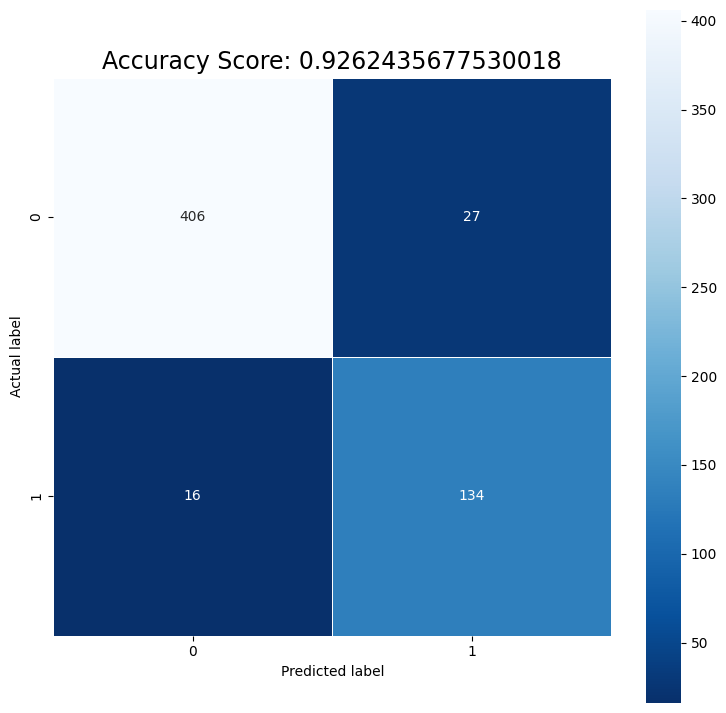

In [ ]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **BorderlineSMOTE**

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       433
           1       0.78      0.87      0.82       150

    accuracy                           0.90       583
   macro avg       0.87      0.89      0.88       583
weighted avg       0.91      0.90      0.91       583



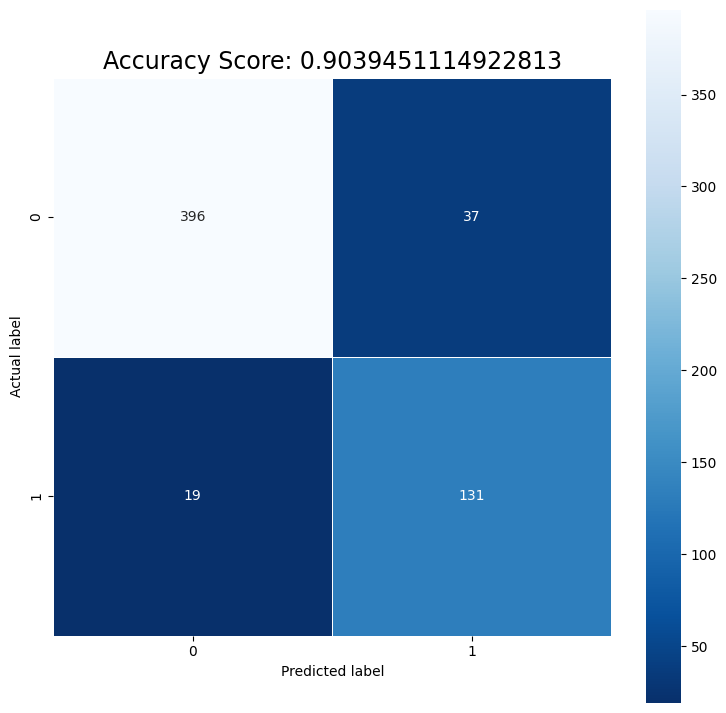

In [ ]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       433
           1       0.83      0.87      0.85       150

    accuracy                           0.92       583
   macro avg       0.89      0.90      0.90       583
weighted avg       0.92      0.92      0.92       583



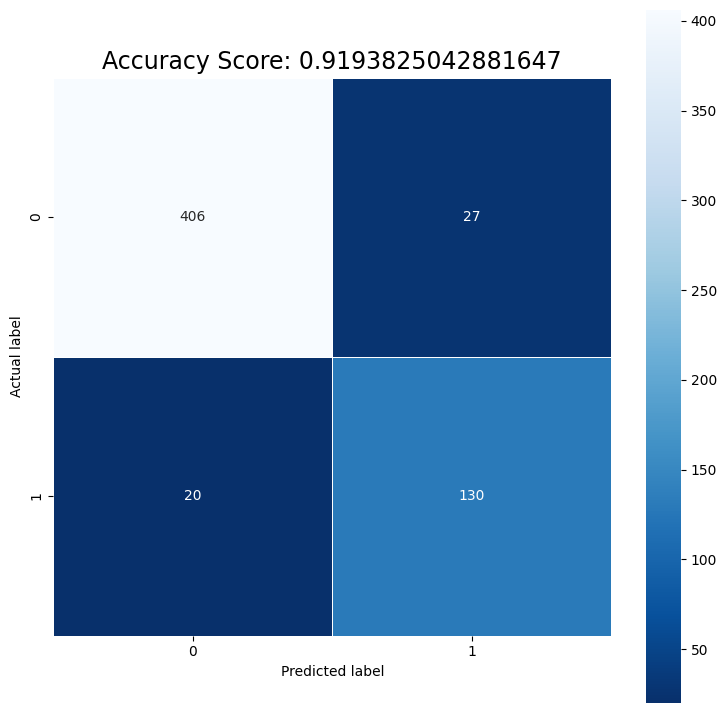

In [ ]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **Exclude instances of no-smell from the training and test sets**


In [ ]:
x_test_multiclass, y_test_multiclass = x_test_csharp_multiclass, y_test_csharp_multiclass

# Find unique classes
unique_classes = np.unique(y_test_multiclass)

# Count the number of classes
number_classes = len(unique_classes)

if (number_classes > 3):

  x_train_multiclass, y_train_multiclass = x_train_multiclass_combined, y_train_multiclass_combined

  finish = False
  while (finish == False):
    try:
      max = x_train_multiclass.shape[0]
      # Exclude instances of no-smell from the training set (targets)
      for i in range(0, max):
        if (y_train_multiclass[i] == 0):
          y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
          x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the y_train set!")
    except:
      finish == False

  finish = False
  while (finish == False):
    try:
      max = x_test_multiclass.shape[0]
      # Exclude instances of no-smell from the test set (predictors)
      for i in range(0, max):
        if (y_test_multiclass[i] == 0):
          y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
          x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the x_train set!")
    except:
      finish = False

  # Original mapping -> Remapping
  mapping = {1.0: 0.0, 2.0: 1.0, 3.0: 2.0, 4.0: 3.0, 5.0: 4.0, 6.0: 5.0, 7.0: 6.0, 8.0: 7.0, 9.0: 8.0, 10.0: 9.0, 11.0: 10.0, 12.0: 11.0}

  y_train_multiclass = np.array([mapping[label] for label in y_train_multiclass])
  y_test_multiclass = np.array([mapping[label] for label in y_test_multiclass])
  print("Prepare training and test set for applying XGBoost")

The deletion is over in the y_train set!
The deletion is over in the x_train set!
Prepare training and test set for applying XGBoost


# **Code Smell Severity Classification with three ensemble method**


# **RANDOM FOREST**

# **Oversampling BorderlineSMOTE**

In [ ]:
pip install imbalanced-learn

# **Randomized**

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         3.0       0.84      0.86      0.85        94
         4.0       0.60      0.59      0.60        44
         5.0       0.78      0.58      0.67        12

    accuracy                           0.76       150
   macro avg       0.55      0.51      0.53       150
weighted avg       0.76      0.76      0.76       150



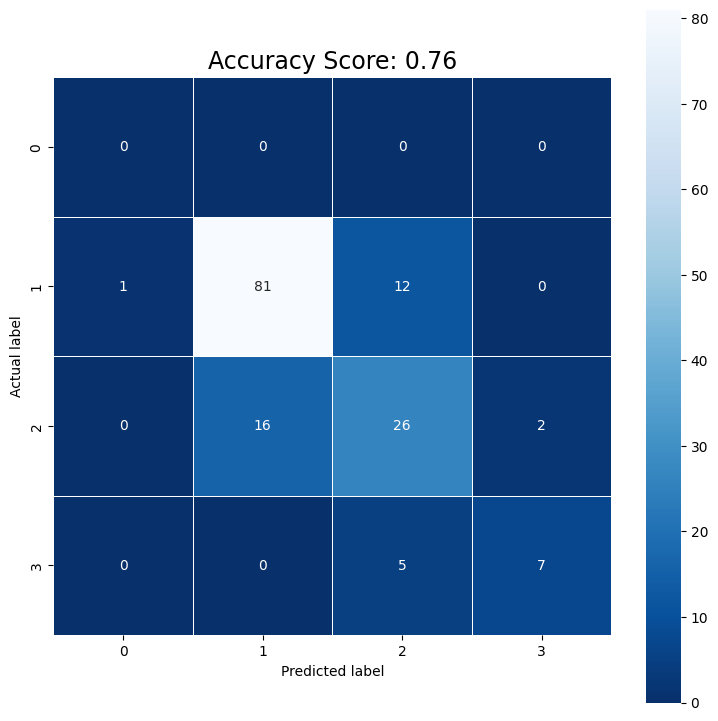

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=970, min_samples_split=7, min_samples_leaf=3, max_features=None, max_depth=6,
                                    criterion='log_loss', bootstrap=True)

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.87      0.86      0.87        94
         4.0       0.60      0.59      0.60        44
         5.0       0.57      0.67      0.62        12

    accuracy                           0.77       150
   macro avg       0.68      0.71      0.69       150
weighted avg       0.77      0.77      0.77       150



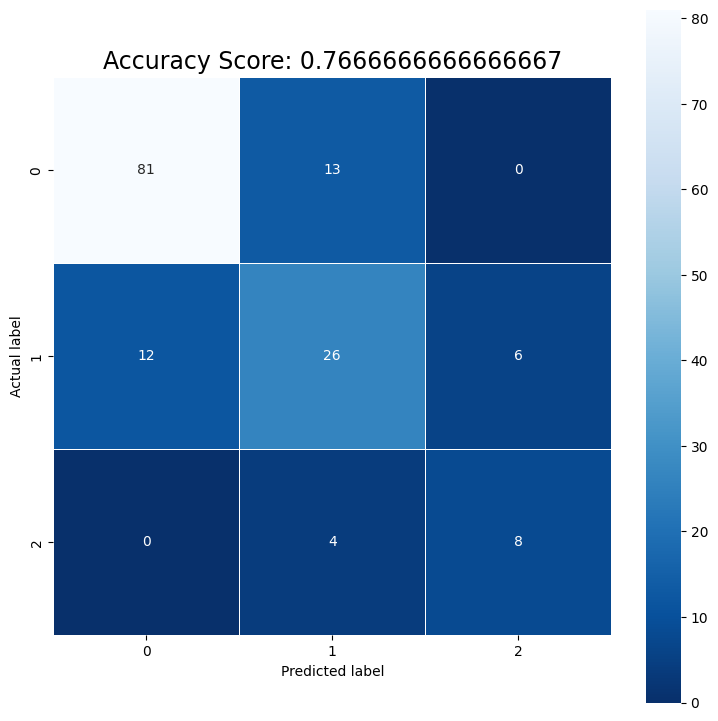

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=524, min_samples_split=12, min_samples_leaf=4, max_features='sqrt', max_depth=13,
                                    criterion='entropy', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.88      0.86      0.87        94
         4.0       0.63      0.61      0.62        44
         5.0       0.53      0.67      0.59        12

    accuracy                           0.77       150
   macro avg       0.68      0.71      0.69       150
weighted avg       0.78      0.77      0.78       150



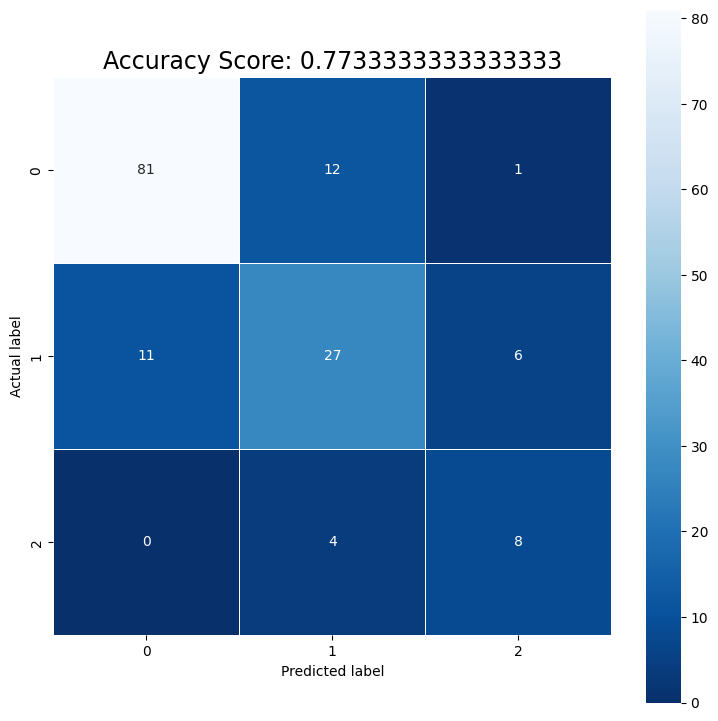

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=118, min_samples_split=12, min_samples_leaf= 3, max_features='sqrt', max_depth=9,
                                    criterion='gini', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **EXTREME GRADIENTE BOOSTING (XGBOOST)**

# **Randomized**

              precision    recall  f1-score   support

         3.0       0.87      0.84      0.85        94
         4.0       0.61      0.64      0.62        44
         5.0       0.62      0.67      0.64        12

    accuracy                           0.77       150
   macro avg       0.70      0.71      0.71       150
weighted avg       0.77      0.77      0.77       150



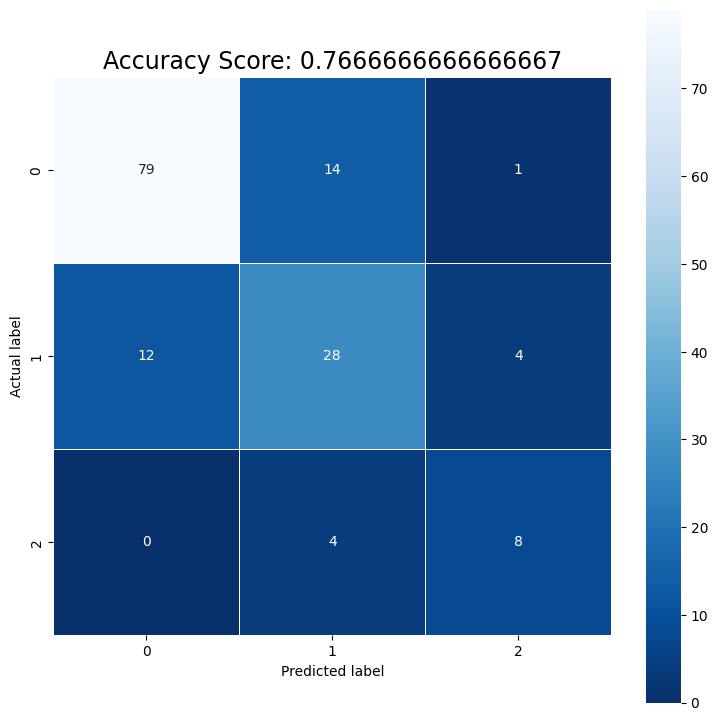

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='approx', objective='multi:softmax', n_estimators=420, max_depth=5,
                           learning_rate=0.5, grow_policy='lossguide', booster='gbtree')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.87      0.86      0.87        94
         4.0       0.59      0.59      0.59        44
         5.0       0.54      0.58      0.56        12

    accuracy                           0.76       150
   macro avg       0.67      0.68      0.67       150
weighted avg       0.76      0.76      0.76       150



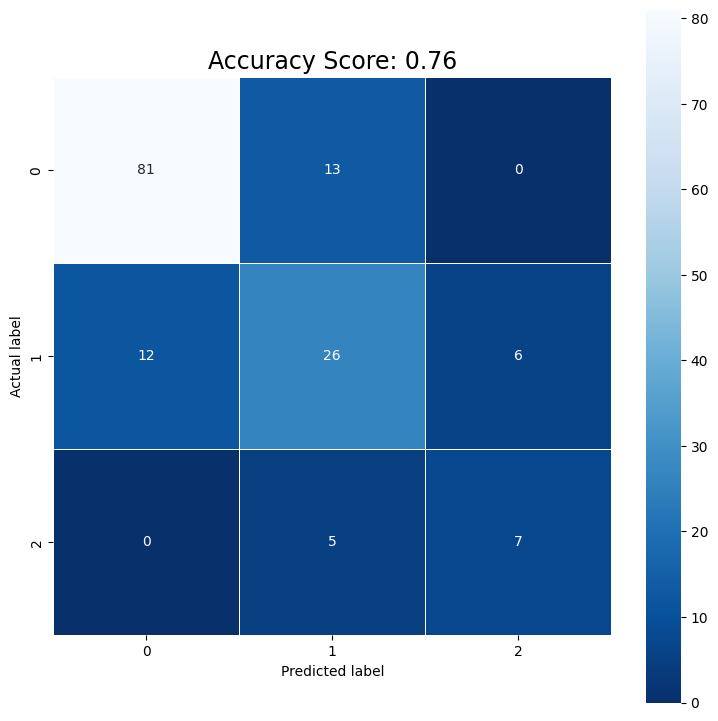

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='hist', objective='multi:softmax', n_estimators=406, max_depth=3,
                           learning_rate=0.3310344827586207, grow_policy='lossguide', booster='gbtree')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.88      0.84      0.86        94
         4.0       0.58      0.57      0.57        44
         5.0       0.47      0.67      0.55        12

    accuracy                           0.75       150
   macro avg       0.64      0.69      0.66       150
weighted avg       0.76      0.75      0.75       150



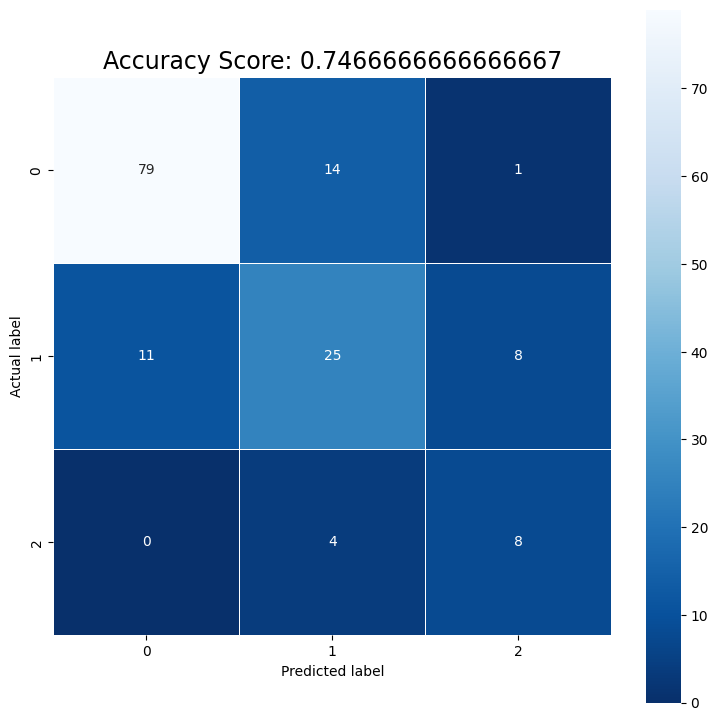

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='approx', objective='multi:softprob', n_estimators=586, max_depth=5,
                           learning_rate=0.5, grow_policy='lossguide', booster='dart')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **CATEGORICAL BOOSTING (CATBOOST)**

In [ ]:
pip install catboost

# **Randomized**

              precision    recall  f1-score   support

         3.0       0.89      0.83      0.86        94
         4.0       0.61      0.64      0.62        44
         5.0       0.56      0.75      0.64        12

    accuracy                           0.77       150
   macro avg       0.69      0.74      0.71       150
weighted avg       0.78      0.77      0.77       150



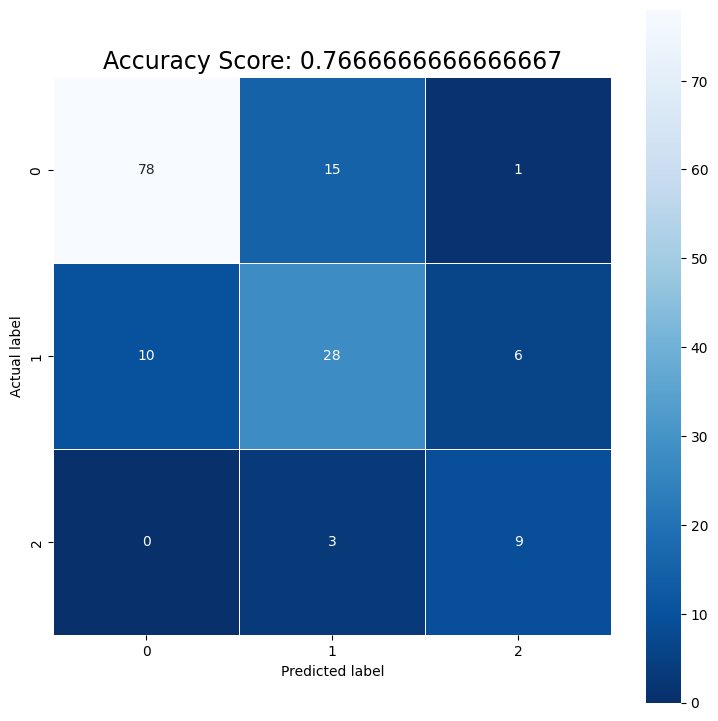

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.16206896551724137, leaf_estimation_method='Newton', l2_leaf_reg=7, iterations=592, grow_policy='Lossguide',
                                feature_border_type='Uniform', depth=6, border_count=192, bootstrap_type='MVS', auto_class_weights='Balanced')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.87      0.87      0.87        94
         4.0       0.61      0.61      0.61        44
         5.0       0.58      0.58      0.58        12

    accuracy                           0.77       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.77      0.77      0.77       150



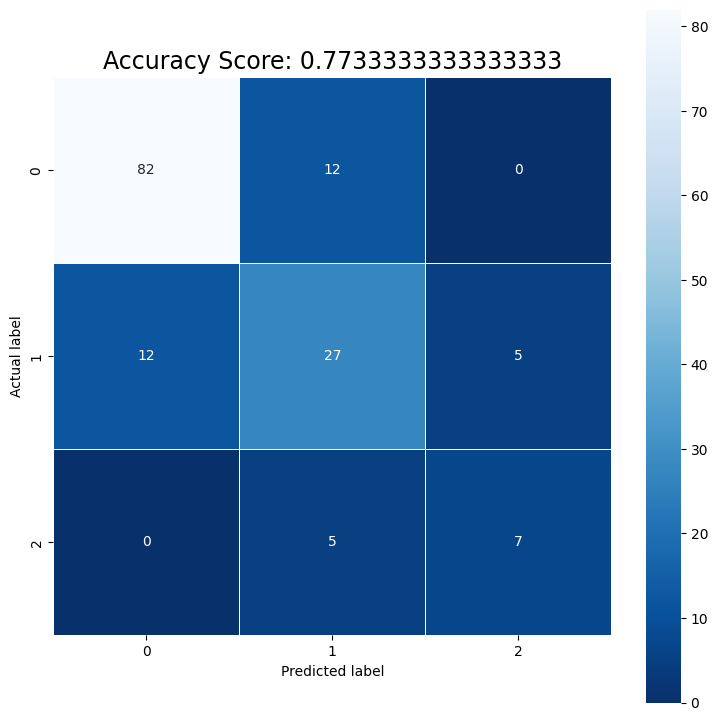

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.3310344827586207, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=734, grow_policy='Depthwise',
                                feature_border_type='GreedyLogSum', depth=15, border_count=96, bootstrap_type='Bayesian', auto_class_weights='SqrtBalanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         3.0       0.87      0.86      0.87        94
         4.0       0.61      0.57      0.59        44
         5.0       0.50      0.67      0.57        12

    accuracy                           0.76       150
   macro avg       0.66      0.70      0.68       150
weighted avg       0.76      0.76      0.76       150



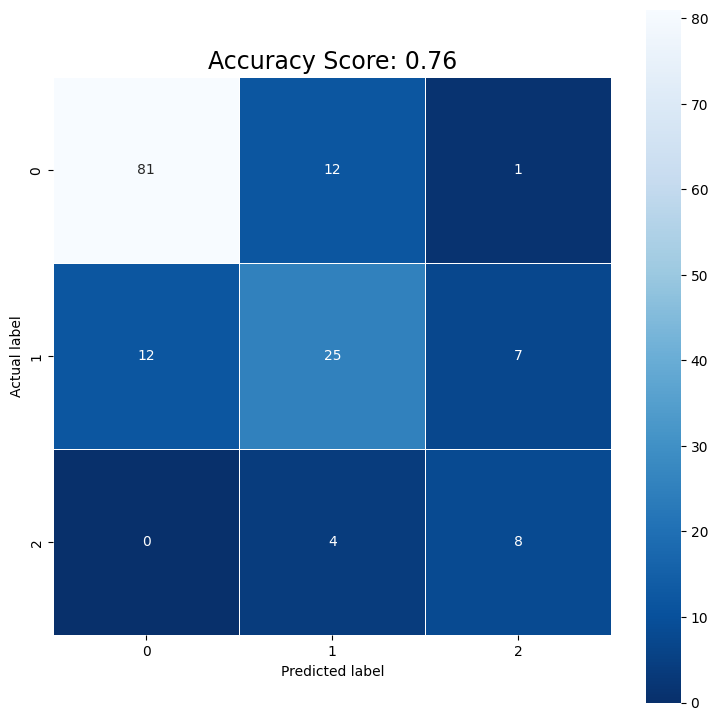

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.07758620689655171, leaf_estimation_method='Gradient', l2_leaf_reg=8, iterations=548, grow_policy='Depthwise',
                                feature_border_type='GreedyLogSum', depth=6, border_count=208, bootstrap_type='Bayesian', auto_class_weights='Balanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()